In [5]:
import uproot
import vector
import awkward as ak
import numpy as np
import math
from scipy.sparse import coo_matrix
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import pyhepmc
from pathlib import Path
import glob
import tqdm

In [6]:
def concatenate_root_files(file_paths, tree_name="events", collections=None, max_files=50):
    """
    Open multiple ROOT files and concatenate their arrays.
    
    Parameters:
    -----------
    file_paths : list or str
        List of file paths or glob pattern string (e.g., "path/to/files/*.root")
    tree_name : str
        Name of the tree to read (default: "events")
    collections : list
        List of collections/branches to read. If None, reads all branches
        
    Returns:
    --------
    dict
        Dictionary containing the concatenated arrays and metadata
    """
    # Handle glob patterns
    if isinstance(file_paths, str):
        file_paths = list(glob.glob(file_paths))[:max_files]
    
    all_data = []
    metadata = None
    
    for file_path in tqdm.tqdm(file_paths):
        # Open ROOT file
        fi = uproot.open(file_path)
        arrs = fi[tree_name]
        
        # Get collection IDs from first file
        if metadata is None:
            metadata = fi.get("podio_metadata")
            collectionIDs = {
                k: v
                for k, v in zip(
                    metadata.arrays("events___idTable/m_names")["events___idTable/m_names"][0],
                    metadata.arrays("events___idTable/m_collectionIDs")["events___idTable/m_collectionIDs"][0],
                )
            }
        
        # Read arrays
        if collections is None:
            data = arrs.arrays()
        else:
            data = arrs.arrays(collections)
            
        all_data.append(data)
        
    # Concatenate arrays
    concatenated_data = ak.concatenate(all_data)
    
    return {
        "data": concatenated_data,
        "collectionIDs": collectionIDs
    }


In [7]:
def get_subarr(arrs, subarr_name):
    subfields = [f for f in arrs.fields if subarr_name in f]
    ret = ak.Array({sf: arrs[sf] for sf in subfields})
    return ret

In [8]:
data = concatenate_root_files(
    "/media/joosep/data/cld/subfolder_9/reco_p8_ee_tt_ecm365_*.root",
    collections = None,
)

100%|██████████████████████████████████████████████████████████████████████| 50/50 [02:38<00:00,  3.17s/it]


In [79]:
for f in prop_data.fields:
    if "SiTracks_Refitted" in f:
        print(f)

SiTracks_Refitted.type
SiTracks_Refitted.chi2
SiTracks_Refitted.ndf
SiTracks_Refitted.Nholes
SiTracks_Refitted.subdetectorHitNumbers_begin
SiTracks_Refitted.subdetectorHitNumbers_end
SiTracks_Refitted.subdetectorHoleNumbers_begin
SiTracks_Refitted.subdetectorHoleNumbers_end
SiTracks_Refitted.trackStates_begin
SiTracks_Refitted.trackStates_end
SiTracks_Refitted.trackerHits_begin
SiTracks_Refitted.trackerHits_end
SiTracks_Refitted.tracks_begin
SiTracks_Refitted.tracks_end
_SiTracks_Refitted_trackerHits.index
_SiTracks_Refitted_trackerHits.collectionID
_SiTracks_Refitted_tracks.index
_SiTracks_Refitted_tracks.collectionID
_SiTracks_Refitted_subdetectorHitNumbers
_SiTracks_Refitted_subdetectorHoleNumbers
_SiTracks_Refitted_trackStates.location
_SiTracks_Refitted_trackStates.D0
_SiTracks_Refitted_trackStates.phi
_SiTracks_Refitted_trackStates.omega
_SiTracks_Refitted_trackStates.Z0
_SiTracks_Refitted_trackStates.tanLambda
_SiTracks_Refitted_trackStates.time
_SiTracks_Refitted_trackStates.re

In [26]:
track_coll = "SiTracks_Refitted"
mc_coll = "MCParticles"

prop_data = data["data"]

# maps the recoparticle track/cluster index (in tracks_begin,end and clusters_begin,end)
# to the index in the track/cluster collection
idx_rp_to_cluster = prop_data["_PandoraPFOs_clusters.index"]
idx_rp_to_track = prop_data["_PandoraPFOs_tracks.index"]

hit_data = {
    "ECALBarrel": get_subarr(prop_data, "ECALBarrel"),
    "ECALEndcap": get_subarr(prop_data, "ECALEndcap"),
    "HCALBarrel": get_subarr(prop_data, "HCALBarrel"),
    "HCALEndcap": get_subarr(prop_data, "HCALEndcap"),
    "HCALOther": get_subarr(prop_data, "HCALOther"),
    "MUON": get_subarr(prop_data, "MUON"),
}

def track_pt(omega):
    a = 3 * 10**-4
    b = 4  # B-field in tesla, from clicRec_e4h_input

    return a * np.abs(b / omega)

def gen_to_features(prop_data, iev):
    gen_arr = prop_data[iev]
    gen_arr = {k.replace(mc_coll + ".", ""): gen_arr[k] for k in gen_arr.fields}

    MCParticles_p4 = vector.awk(
        ak.zip({"mass": gen_arr["mass"], "x": gen_arr["momentum.x"], "y": gen_arr["momentum.y"], "z": gen_arr["momentum.z"]})
    )
    gen_arr["pt"] = MCParticles_p4.pt
    gen_arr["eta"] = MCParticles_p4.eta
    gen_arr["phi"] = MCParticles_p4.phi
    gen_arr["energy"] = MCParticles_p4.energy
    gen_arr["sin_phi"] = np.sin(gen_arr["phi"])
    gen_arr["cos_phi"] = np.cos(gen_arr["phi"])

    # placeholder flag
    gen_arr["ispu"] = np.zeros_like(gen_arr["phi"])

    return {
        "PDG": gen_arr["PDG"],
        "generatorStatus": gen_arr["generatorStatus"],
        "charge": gen_arr["charge"],
        "pt": gen_arr["pt"],
        "eta": gen_arr["eta"],
        "phi": gen_arr["phi"],
        "sin_phi": gen_arr["sin_phi"],
        "cos_phi": gen_arr["cos_phi"],
        "energy": gen_arr["energy"],
        "ispu": gen_arr["ispu"],
        "simulatorStatus": gen_arr["simulatorStatus"],
        "gp_to_track": np.zeros(len(gen_arr["PDG"]), dtype=np.float64),
        "gp_to_cluster": np.zeros(len(gen_arr["PDG"]), dtype=np.float64),
        "jet_idx": np.zeros(len(gen_arr["PDG"]), dtype=np.int64),
        "daughters_begin": gen_arr["daughters_begin"],
        "daughters_end": gen_arr["daughters_end"],
        "index": prop_data["_MCParticles_daughters.index"][iev]
    }

def get_calohit_matrix_and_genadj(hit_data, calohit_links, iev, collectionIDs):
    feats = ["type", "cellID", "energy", "energyError", "time", "position.x", "position.y", "position.z"]

    hit_idx_global = 0
    hit_idx_global_to_local = {}
    hit_feature_matrix = []
    for col in sorted(hit_data.keys()):
        icol = collectionIDs[col]
        hit_features = hits_to_features(hit_data[col], iev, col, feats)
        hit_feature_matrix.append(hit_features)
        for ihit in range(len(hit_data[col][col + ".energy"][iev])):
            hit_idx_global_to_local[hit_idx_global] = (icol, ihit)
            hit_idx_global += 1
    hit_idx_local_to_global = {v: k for k, v in hit_idx_global_to_local.items()}
    hit_feature_matrix = ak.Record(
        {k: ak.concatenate([hit_feature_matrix[i][k] for i in range(len(hit_feature_matrix))]) for k in hit_feature_matrix[0].fields}
    )

    # add all edges from genparticle to calohit
    calohit_to_gen_weight = prop_data["CalohitMCTruthLink.weight"][iev]
    calohit_to_gen_calo_colid = prop_data["_CalohitMCTruthLink_from.collectionID"][iev]
    calohit_to_gen_gen_colid = prop_data["_CalohitMCTruthLink_to.collectionID"][iev]
    calohit_to_gen_calo_idx = prop_data["_CalohitMCTruthLink_from.index"][iev]
    calohit_to_gen_gen_idx = prop_data["_CalohitMCTruthLink_to.index"][iev]
    genparticle_to_hit_matrix_coo0 = []
    genparticle_to_hit_matrix_coo1 = []
    genparticle_to_hit_matrix_w = []
    for calo_colid, calo_idx, gen_colid, gen_idx, w in zip(
        calohit_to_gen_calo_colid,
        calohit_to_gen_calo_idx,
        calohit_to_gen_gen_colid,
        calohit_to_gen_gen_idx,
        calohit_to_gen_weight,
    ):
        genparticle_to_hit_matrix_coo0.append(gen_idx)
        genparticle_to_hit_matrix_coo1.append(hit_idx_local_to_global[(calo_colid, calo_idx)])
        genparticle_to_hit_matrix_w.append(w)

    return (
        hit_feature_matrix,
        (np.array(genparticle_to_hit_matrix_coo0), np.array(genparticle_to_hit_matrix_coo1), np.array(genparticle_to_hit_matrix_w)),
        hit_idx_local_to_global,
    )

def hits_to_features(hit_data, iev, coll, feats):
    feat_arr = {f: hit_data[coll + "." + f][iev] for f in feats}

    # set the subdetector type
    sdcoll = "subdetector"
    feat_arr[sdcoll] = np.zeros(len(feat_arr["type"]), dtype=np.int32)
    if coll.startswith("ECAL"):
        feat_arr[sdcoll][:] = 0
    elif coll.startswith("HCAL"):
        feat_arr[sdcoll][:] = 1
    else:
        feat_arr[sdcoll][:] = 2

    # hit elemtype is always 2
    feat_arr["elemtype"] = 2 * np.ones(len(feat_arr["type"]), dtype=np.int32)

    # precompute some approximate et, eta, phi
    pos_mag = np.sqrt(feat_arr["position.x"] ** 2 + feat_arr["position.y"] ** 2 + feat_arr["position.z"] ** 2)
    px = (feat_arr["position.x"] / pos_mag) * feat_arr["energy"]
    py = (feat_arr["position.y"] / pos_mag) * feat_arr["energy"]
    pz = (feat_arr["position.z"] / pos_mag) * feat_arr["energy"]
    feat_arr["et"] = np.sqrt(px**2 + py**2)
    feat_arr["eta"] = 0.5 * np.log((feat_arr["energy"] + pz) / (feat_arr["energy"] - pz))
    feat_arr["sin_phi"] = py / feat_arr["energy"]
    feat_arr["cos_phi"] = px / feat_arr["energy"]

    return ak.Record(feat_arr)

def hit_cluster_adj(prop_data, hit_idx_local_to_global, iev):
    coll_arr = prop_data["_PandoraClusters_hits.collectionID"][iev]
    idx_arr = prop_data["_PandoraClusters_hits.index"][iev]
    hits_begin = prop_data["PandoraClusters.hits_begin"][iev]
    hits_end = prop_data["PandoraClusters.hits_end"][iev]

    # index in the array of all hits
    hit_to_cluster_matrix_coo0 = []
    # index in the cluster array
    hit_to_cluster_matrix_coo1 = []

    # weight
    hit_to_cluster_matrix_w = []

    # loop over all clusters
    for icluster in range(len(hits_begin)):

        # get the slice in the hit array corresponding to this cluster
        hbeg = hits_begin[icluster]
        hend = hits_end[icluster]
        idx_range = idx_arr[hbeg:hend]
        coll_range = coll_arr[hbeg:hend]

        # add edges from hit to cluster
        for icol, idx in zip(coll_range, idx_range):
            hit_to_cluster_matrix_coo0.append(hit_idx_local_to_global[(icol, idx)])
            hit_to_cluster_matrix_coo1.append(icluster)
            hit_to_cluster_matrix_w.append(1.0)
    return hit_to_cluster_matrix_coo0, hit_to_cluster_matrix_coo1, hit_to_cluster_matrix_w

def track_to_features(prop_data, iev):

    track_arr = get_subarr(prop_data, track_coll)[iev]
    # the following are needed since they are no longer defined under SiTracks_Refitted
    track_arr_dQdx = prop_data["SiTracks_Refitted_dQdx"][iev]
    track_arr_trackStates = prop_data["_SiTracks_Refitted_trackStates"][iev]

    feats_from_track = ["type", "chi2", "ndf"]
    ret = {feat: track_arr[track_coll + "." + feat] for feat in feats_from_track}

    ret["dEdx"] = track_arr_dQdx["SiTracks_Refitted_dQdx.dQdx.value"]
    ret["dEdxError"] = track_arr_dQdx["SiTracks_Refitted_dQdx.dQdx.error"]

    # build the radiusOfInnermostHit variable
    num_tracks = len(ret["dEdx"])
    innermost_radius = []
    for itrack in range(num_tracks):

        # select the track states corresponding to itrack
        # pick the state AtFirstHit
        # https://github.com/key4hep/EDM4hep/blob/fe5a54046a91a7e648d0b588960db7841aebc670/edm4hep.yaml#L220
        ibegin = track_arr[track_coll + "." + "trackStates_begin"][itrack]
        iend = track_arr[track_coll + "." + "trackStates_end"][itrack]

        refX = track_arr_trackStates["_SiTracks_Refitted_trackStates" + "." + "referencePoint.x"][ibegin:iend]
        refY = track_arr_trackStates["_SiTracks_Refitted_trackStates" + "." + "referencePoint.y"][ibegin:iend]
        location = track_arr_trackStates["_SiTracks_Refitted_trackStates" + "." + "location"][ibegin:iend]

        istate = np.argmax(location == 2)  # 2 refers to AtFirstHit

        innermost_radius.append(math.sqrt(refX[istate] ** 2 + refY[istate] ** 2))

    ret["radiusOfInnermostHit"] = np.array(innermost_radius)
    feats_from_track = ["type", "chi2", "ndf"]
    ret = {feat: track_arr[track_coll + "." + feat] for feat in feats_from_track}
    n_tr = len(ret["type"])

    # get the index of the first track state
    trackstate_idx = prop_data[track_coll][track_coll + ".trackStates_begin"][iev]
    # get the properties of the track at the first track state (at the origin)
    for k in ["tanLambda", "D0", "phi", "omega", "Z0", "time"]:
        ret[k] = ak.to_numpy(prop_data["_SiTracks_Refitted_trackStates"]["_SiTracks_Refitted_trackStates." + k][iev][trackstate_idx])

    ret["pt"] = ak.to_numpy(track_pt(ret["omega"]))
    ret["px"] = ak.to_numpy(np.cos(ret["phi"])) * ret["pt"]
    ret["py"] = ak.to_numpy(np.sin(ret["phi"])) * ret["pt"]
    ret["pz"] = ak.to_numpy(ret["tanLambda"]) * ret["pt"]
    ret["p"] = np.sqrt(ret["px"] ** 2 + ret["py"] ** 2 + ret["pz"] ** 2)
    cos_theta = np.divide(ret["pz"], ret["p"], where=ret["p"] > 0)
    theta = np.arccos(cos_theta)
    tt = np.tan(theta / 2.0)
    eta = ak.to_numpy(-np.log(tt, where=tt > 0))
    eta[tt <= 0] = 0.0
    ret["eta"] = eta

    ret["sin_phi"] = np.sin(ret["phi"])
    ret["cos_phi"] = np.cos(ret["phi"])

    # track is always type 1
    ret["elemtype"] = 1 * np.ones(n_tr, dtype=np.float32)

    return ak.Record(ret)

def genparticle_track_adj(sitrack_links, iev):
    trk_to_gen_trkidx = prop_data["_SiTracksMCTruthLink_from.index"][iev]
    trk_to_gen_genidx = prop_data["_SiTracksMCTruthLink_to.index"][iev]
    trk_to_gen_w = prop_data["SiTracksMCTruthLink.weight"][iev]

    genparticle_to_track_matrix_coo0 = ak.to_numpy(trk_to_gen_genidx)
    genparticle_to_track_matrix_coo1 = ak.to_numpy(trk_to_gen_trkidx)
    genparticle_to_track_matrix_w = ak.to_numpy(trk_to_gen_w)

    return genparticle_to_track_matrix_coo0, genparticle_to_track_matrix_coo1, genparticle_to_track_matrix_w

def cluster_to_features(prop_data, hit_features, hit_to_cluster, iev):
    cluster_arr = get_subarr(prop_data, "PandoraClusters")[iev]
    feats = ["type", "position.x", "position.y", "position.z", "iTheta", "phi", "energy"]
    ret = {feat: cluster_arr["PandoraClusters." + feat] for feat in feats}

    hit_idx = np.array(hit_to_cluster[0])
    cluster_idx = np.array(hit_to_cluster[1])
    cl_energy_ecal = []
    cl_energy_hcal = []
    cl_energy_other = []
    num_hits = []
    cl_sigma_x = []
    cl_sigma_y = []
    cl_sigma_z = []

    n_cl = len(ret["energy"])
    for cl in range(n_cl):
        msk_cl = cluster_idx == cl
        hits = hit_idx[msk_cl]

        num_hits.append(len(hits))

        subdets = hit_features["subdetector"][hits]

        hits_energy = hit_features["energy"][hits]

        hits_posx = hit_features["position.x"][hits]
        hits_posy = hit_features["position.y"][hits]
        hits_posz = hit_features["position.z"][hits]

        energy_ecal = np.sum(hits_energy[subdets == 0])
        energy_hcal = np.sum(hits_energy[subdets == 1])
        energy_other = np.sum(hits_energy[subdets == 2])

        cl_energy_ecal.append(energy_ecal)
        cl_energy_hcal.append(energy_hcal)
        cl_energy_other.append(energy_other)

        # weighted standard deviation of cluster hits
        sigma_x = weighted_avg_and_std(hits_posx, hits_energy)[1]
        sigma_y = weighted_avg_and_std(hits_posy, hits_energy)[1]
        sigma_z = weighted_avg_and_std(hits_posz, hits_energy)[1]
        cl_sigma_x.append(sigma_x)
        cl_sigma_y.append(sigma_y)
        cl_sigma_z.append(sigma_z)

    ret["energy_ecal"] = np.array(cl_energy_ecal)
    ret["energy_hcal"] = np.array(cl_energy_hcal)
    ret["energy_other"] = np.array(cl_energy_other)
    ret["num_hits"] = np.array(num_hits)
    ret["sigma_x"] = np.array(cl_sigma_x)
    ret["sigma_y"] = np.array(cl_sigma_y)
    ret["sigma_z"] = np.array(cl_sigma_z)

    tt = ak.to_numpy(np.tan(ret["iTheta"] / 2.0))
    eta = ak.to_numpy(-np.log(tt, where=tt > 0))
    eta[tt <= 0] = 0.0
    ret["eta"] = eta

    costheta = np.cos(ret["iTheta"])
    ez = ret["energy"] * costheta
    ret["et"] = np.sqrt(ret["energy"] ** 2 - ez**2)

    # cluster is always type 2
    ret["elemtype"] = 2 * np.ones(n_cl, dtype=np.float32)

    ret["sin_phi"] = np.sin(ret["phi"])
    ret["cos_phi"] = np.cos(ret["phi"])

    return ak.Record(ret)

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    They weights are in effect first normalized so that they
    sum to 1 (and so they must not all be 0).

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values - average) ** 2, weights=weights)
    return (average, math.sqrt(variance))

def add_daughters_to_status1(gen_features, genparticle_to_hit, genparticle_to_trk):
    mask_status1 = gen_features["generatorStatus"] == 1
    dau_beg = gen_features["daughters_begin"]
    dau_end = gen_features["daughters_end"]
    dau_ind = gen_features["index"]
    genparticle_to_hit_additional_gp = []
    genparticle_to_hit_additional_hit = []
    genparticle_to_hit_additional_w = []
    genparticle_to_trk_additional_gp = []
    genparticle_to_trk_additional_trk = []
    genparticle_to_trk_additional_w = []
    for idx_st1 in np.where(mask_status1)[0]:
        pdg = abs(gen_features["PDG"][idx_st1])
        if pdg not in [12, 14, 16]:
            db = dau_beg[idx_st1]
            de = dau_end[idx_st1]
            daus = dau_ind[db:de]
            for dau in daus:
                dau_hit_idx = genparticle_to_hit[1][genparticle_to_hit[0] == dau]
                dau_hit_w = genparticle_to_hit[2][genparticle_to_hit[0] == dau]
                for dh_idx, dh_w in zip(dau_hit_idx, dau_hit_w):
                    genparticle_to_hit_additional_gp.append(idx_st1)
                    genparticle_to_hit_additional_hit.append(dh_idx)
                    genparticle_to_hit_additional_w.append(dh_w)

                dau_trk_idx = genparticle_to_trk[1][genparticle_to_trk[0] == dau]
                dau_trk_w = genparticle_to_trk[2][genparticle_to_trk[0] == dau]
                for dt_idx, dt_w in zip(dau_trk_idx, dau_trk_w):
                    genparticle_to_trk_additional_gp.append(idx_st1)
                    genparticle_to_trk_additional_trk.append(dt_idx)
                    genparticle_to_trk_additional_w.append(dt_w)

    genparticle_to_hit = (
        np.concatenate([genparticle_to_hit[0], genparticle_to_hit_additional_gp]),
        np.concatenate([genparticle_to_hit[1], genparticle_to_hit_additional_hit]),
        np.concatenate([genparticle_to_hit[2], genparticle_to_hit_additional_w]),
    )
    genparticle_to_trk = (
        np.concatenate([genparticle_to_trk[0], genparticle_to_trk_additional_gp]),
        np.concatenate([genparticle_to_trk[1], genparticle_to_trk_additional_trk]),
        np.concatenate([genparticle_to_trk[2], genparticle_to_trk_additional_w]),
    )
    return genparticle_to_hit, genparticle_to_trk

In [27]:
import copy

In [41]:
ch_links_to = prop_data["_CalohitMCTruthLink_to.index"]
ch_w = prop_data["CalohitMCTruthLink.weight"]

tr_links_to = prop_data["_SiTracksMCTruthLink_to.index"]
tr_w = prop_data["SiTracksMCTruthLink.weight"]

In [42]:
hit_arrs = []
for iev in range(len(ch_links_to)):
    arr = 0*np.array(prop_data["MCParticles.mass"][iev])
    for ihit, w in zip(ch_links_to[iev], ch_w[iev]):
        arr[ihit] += w
    hit_arrs.append(arr)
hit_arr_calo = ak.Array(hit_arrs)

hit_arrs = []
for iev in range(len(tr_links_to)):
    arr = 0*np.array(prop_data["MCParticles.mass"][iev])
    for ihit, w in zip(tr_links_to[iev], tr_w[iev]):
        arr[ihit] += w
    hit_arrs.append(arr)
hit_arr_trk = ak.Array(hit_arrs)

In [43]:
gen_arr = get_subarr(prop_data, "MCParticles")
MCParticles_p4 = vector.awk(
    ak.zip({"mass": gen_arr["MCParticles.mass"], "x": gen_arr["MCParticles.momentum.x"], "y": gen_arr["MCParticles.momentum.y"], "z": gen_arr["MCParticles.momentum.z"]})
)

In [74]:
msk_st1 = gen_arr["MCParticles.generatorStatus"] == 1
msk_st0 = gen_arr["MCParticles.generatorStatus"] == 0

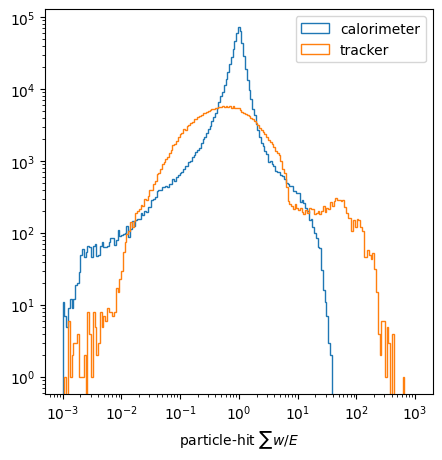

In [73]:
plt.figure(figsize=(5,5))
plt.hist(
    ak.flatten((hit_arr_calo/MCParticles_p4.energy)[hit_arr_calo>0]),
    bins=np.logspace(-3,3,200), histtype="step", label="calorimeter");
plt.hist(
    ak.flatten((hit_arr_trk/MCParticles_p4.energy)[hit_arr_trk>0]),
    bins=np.logspace(-3,3,200), histtype="step", label="tracker");
plt.yscale("log")
plt.xscale("log")
plt.xlabel("particle-hit $\sum{w} / E$")
plt.legend()

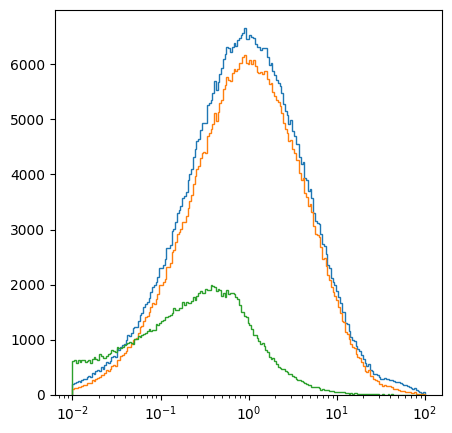

In [75]:
plt.figure(figsize=(5,5))
plt.hist(
    ak.flatten(MCParticles_p4.pt[msk_st1]), bins=np.logspace(-2, 2, 200),
    histtype="step", label="status 1 particles"
);

plt.hist(
    ak.flatten(MCParticles_p4.pt[(msk_st1) & (hit_arr>0.0)]), bins=np.logspace(-2, 2, 200),
    histtype="step", label="status 1 with hits"
);

plt.hist(
    ak.flatten(MCParticles_p4.pt[(msk_st0) & (hit_arr>0.0)]), bins=np.logspace(-2, 2, 200),
    histtype="step", label="status 0 with hits"
);

plt.xscale("log")

In [21]:
calohit_links = get_subarr(prop_data, "CalohitMCTruthLink")
calohit_links

<Array [{...}, {...}, {...}, ..., {...}, {...}] type='5000 * {"CalohitMCTru...'>

In [23]:
data["collectionIDs"]

{'EventHeader': 3616779153,
 'MCParticles': 2714477136,
 'InnerTrackerBarrelCollection': 4118038771,
 'InnerTrackerEndcapCollection': 1836205715,
 'OuterTrackerBarrelCollection': 138199101,
 'OuterTrackerEndcapCollection': 340844528,
 'VertexBarrelCollection': 2246476560,
 'VertexEndcapCollection': 1524465474,
 'ECalBarrelCollection': 1082044795,
 'ECalBarrelCollectionContributions': 75357852,
 'ECalEndcapCollection': 201957718,
 'ECalEndcapCollectionContributions': 2470584824,
 'HCalBarrelCollection': 1840200513,
 'HCalBarrelCollectionContributions': 1146136818,
 'HCalEndcapCollection': 1356401389,
 'HCalEndcapCollectionContributions': 2191725667,
 'HCalRingCollection': 2910502858,
 'HCalRingCollectionContributions': 995571814,
 'LumiCalCollection': 1165332501,
 'LumiCalCollectionContributions': 3669141454,
 'YokeBarrelCollection': 2545921446,
 'YokeBarrelCollectionContributions': 1578098675,
 'YokeEndcapCollection': 1612748112,
 'YokeEndcapCollectionContributions': 1760973346,
 'Buil

In [76]:
iev = 0

gen_features = gen_to_features(prop_data, iev)
hit_features, genparticle_to_hit, hit_idx_local_to_global = get_calohit_matrix_and_genadj(hit_data, calohit_links, iev, data["collectionIDs"])
hit_to_cluster = hit_cluster_adj(prop_data, hit_idx_local_to_global, iev)
cluster_features = cluster_to_features(prop_data, hit_features, hit_to_cluster, iev)
track_features = track_to_features(prop_data, iev)
genparticle_to_trk = genparticle_track_adj(sitrack_links, iev)

mask_status1 = gen_features["generatorStatus"] == 1
genparticle_to_hit, genparticle_to_trk = add_daughters_to_status1(gen_features, genparticle_to_hit, genparticle_to_trk)

FieldNotFoundError: no field 'SiTracks_Refitted_dQdx' in record with 598 fields

In [ ]:
n_gp = ak.count(gen_features["PDG"])
n_track = ak.count(track_features["type"])
n_hit = ak.count(hit_features["type"])
n_cluster = ak.count(cluster_features["type"])

In [ ]:
n_gp, n_track, n_hit, n_cluster

In [ ]:
gp_to_track = coo_matrix((genparticle_to_trk[2], (genparticle_to_trk[0], genparticle_to_trk[1])), shape=(n_gp, n_track)).max(axis=1).todense()

In [ ]:
gp_to_calohit = coo_matrix((genparticle_to_hit[2], (genparticle_to_hit[0], genparticle_to_hit[1])), shape=(n_gp, n_hit))
calohit_to_cluster = coo_matrix((hit_to_cluster[2], (hit_to_cluster[0], hit_to_cluster[1])), shape=(n_hit, n_cluster))
gp_to_cluster = (gp_to_calohit * calohit_to_cluster).sum(axis=1)

In [ ]:
gp_to_cluster.shape, gp_to_track.shape

In [ ]:
# 20% of the hits of a track must come from the genparticle
gp_in_tracker = np.array(gp_to_track >= 0.2)[:, 0]

# at least 5% of the energy of the genparticle should be matched to a calorimeter cluster
gp_in_calo = (np.array(gp_to_cluster)[:, 0] / gen_features["energy"]) > 0.05

gp_interacted_with_detector = gp_in_tracker | gp_in_calo

gen_features["gp_to_track"] = np.asarray(gp_to_track)[:, 0]
gen_features["gp_to_cluster"] = np.asarray(gp_to_cluster)[:, 0]

mask_visible = ak.to_numpy(mask_status1 & gp_interacted_with_detector)

In [ ]:
def gen_to_graph(gen_features):
    g = nx.DiGraph()
    for igp in range(len(gen_features["PDG"])):
        g.add_node(igp)

    for igen, (dau_beg, dau_end) in enumerate(zip(gen_features["daughters_begin"], gen_features["daughters_end"])):
        dau_ind = gen_features["index"]
        for idau in dau_ind[dau_beg:dau_end]:
            if idau != igen:
                g.add_edge(igen, idau)
    return g

In [ ]:
g = gen_to_graph(gen_features)

In [ ]:
def color_node(st):
    if st == 0:
        return "red"
    elif st == 1:
        return "blue"
    elif st == 2:
        return "green"
    else:
        return "gray"

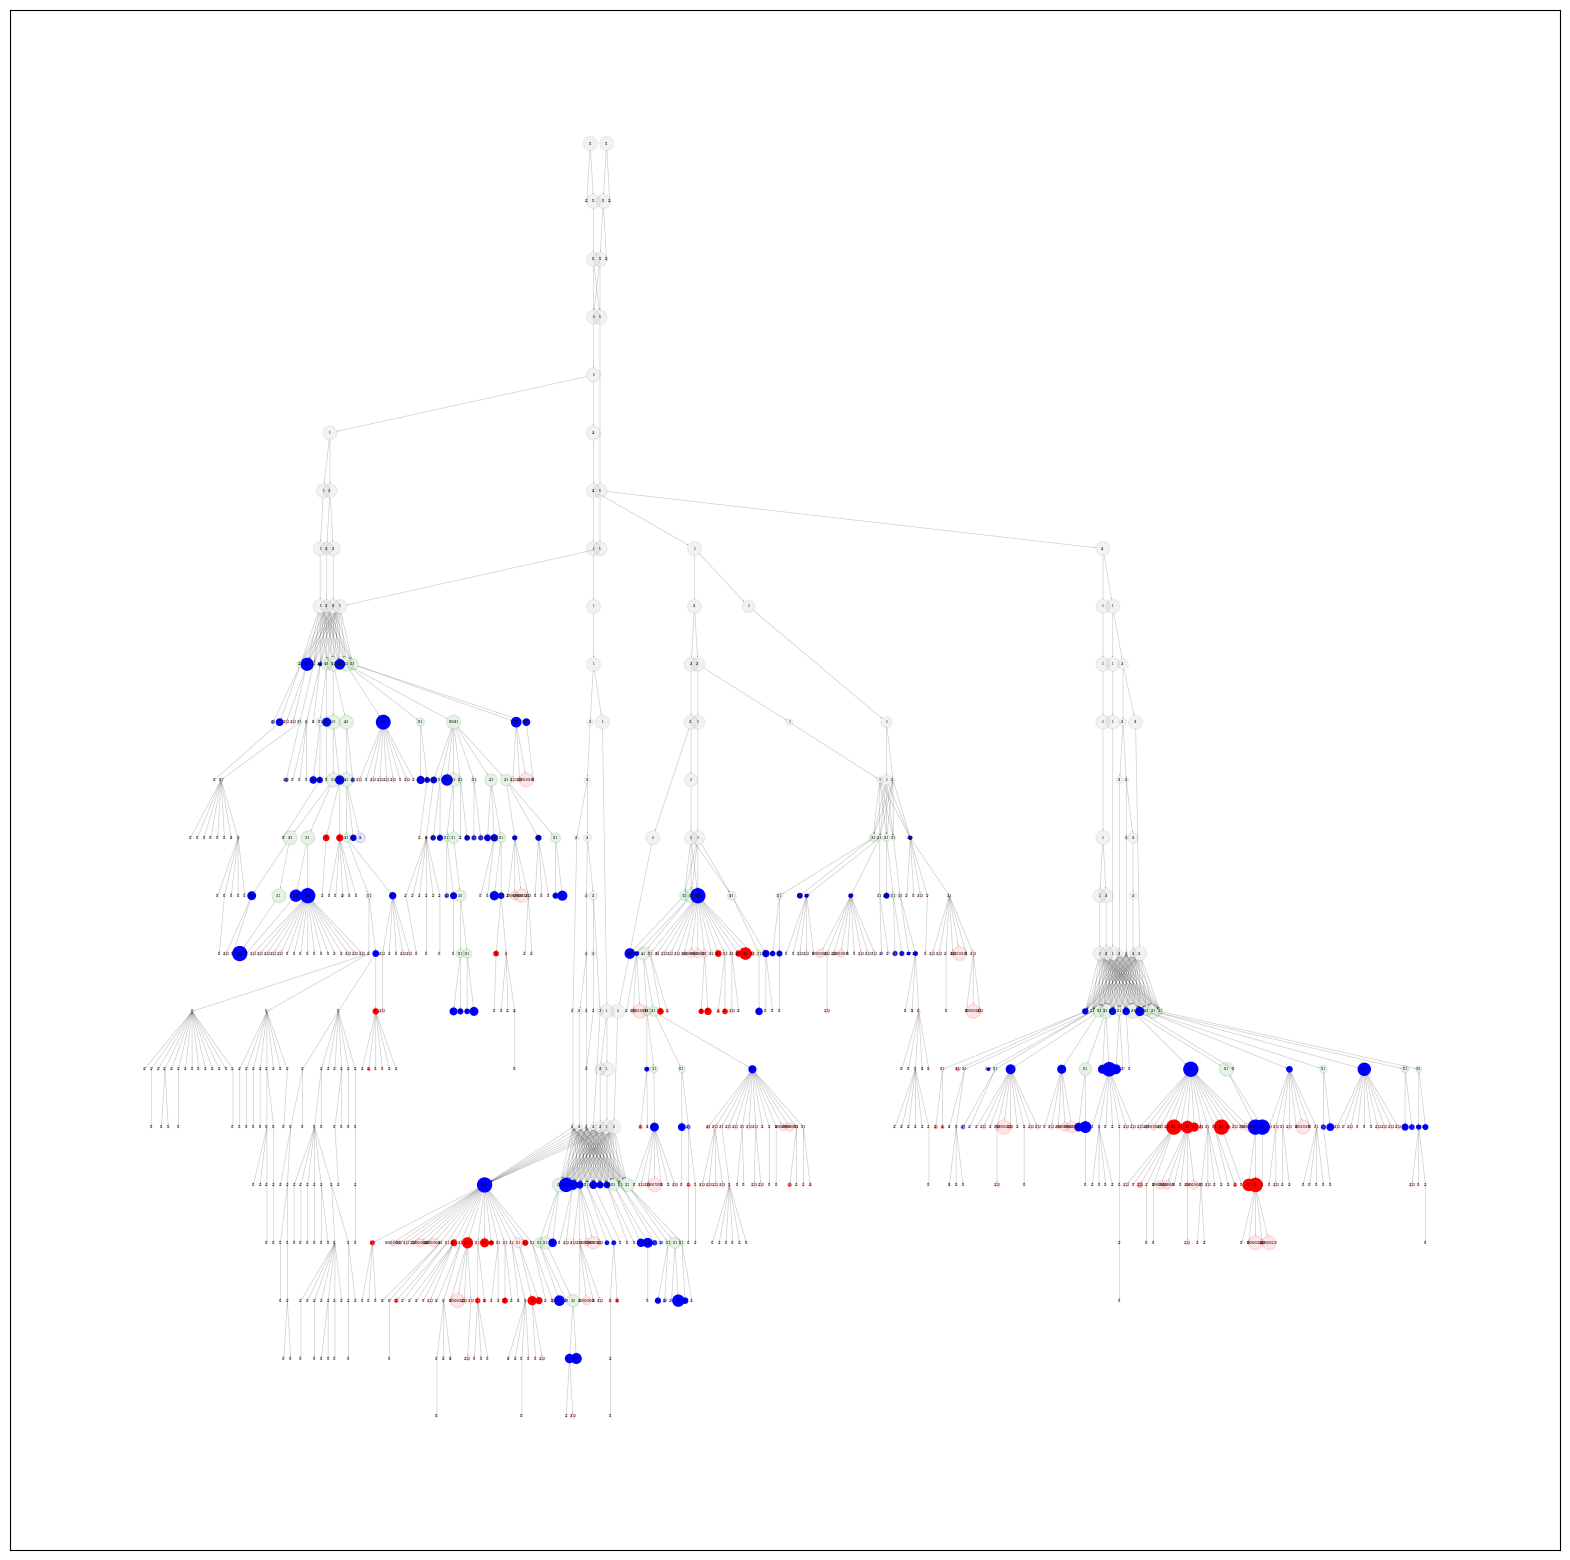

In [405]:
node_color = [color_node(st) for st in gen_features["generatorStatus"]]
node_size = [np.clip(10*e, 1, 100) for e in gen_features["energy"]]
# node_size = [5+ssg.nodes[n]["energy"] for n in ssg.nodes]
alpha1 = [np.clip(x, 0.1, 1.0) for x in np.array(gp_to_cluster)[:, 0]]
alpha2 = [np.clip(x, 0.1, 1.0) for x in np.array(gp_to_track)[:, 0]]
alpha = [max(a1, a2) for a1, a2 in zip(alpha1, alpha2)]
labels = {n: "{}".format(abs(pid))+("*" if vis else "") for n, pid, vis in zip(g.nodes, gen_features["PDG"], mask_visible)}
pos = nx.nx_agraph.graphviz_layout(g, prog="dot")
fig = plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(
    g, pos,
    node_color=node_color,
    node_size=node_size,
    alpha = alpha,
);
nx.draw_networkx_edges(
    g, pos, arrowsize=1, width=0.5, alpha=0.2,
    node_size=node_size,
);
nx.draw_networkx_labels(
    g, pos,
    labels=labels,
    font_size=2
);
plt.savefig("graph.pdf")

In [416]:
import json
import glob

In [429]:
split_totals = {"train": 0, "test": 0}
for ds in glob.glob("/media/joosep/data/tensorflow_datasets/clic_edm_*/*/2.5.0/dataset_info.json"):
    splits = json.load(open(ds))["splits"]
    for spl in splits:
        x = sum([int(x) for x in spl["shardLengths"]])
        split_totals[spl["name"]] += x

In [431]:
split_totals["train"],split_totals["test"]

(21536352, 2393061)